In [1]:
from IPython.display import Image, HTML

import getml

try:
    getml.engine.delete_project('getting_started')
except OSError:
    pass

# Get started with getML

In this example, you will learn about the basic concepts of getML. You will tackle a simple problem using the Python API in order to gain a technical understanding of the benefits of getML. More specifically, you will learn how to do the following:

1. [Start a new project](#starting-a-new-project)
2. [Define a data model](#defining-the-data-model)
3. [Train a ML model](#training-a-model)

You have not installed getML on your machine yet? Head over to the [installation instructions](https://docs.get.ml/latest/home/installation/installation.html) before you get started.

**Introduction**

Automated machine learning (AutoML) has attracted a great deal of attention in recent years. The goal is to simplify the application of traditional machine learning methods to real world business problems by automating key steps of a data science project, such as feature extraction, model selection, and hyperparameter optimization. With AutoML, data scientists are able to develop and compare dozens of models, gain insights, generate predictions, and solve more business problems in less time.

While it is often claimed that AutoML covers the complete workflow of a data science project - from the raw data set to the deployable machine learning models - current solutions have one major drawback: They cannot handle *real world* business data. This data typically comes in the form relational data. The relevant information is scattered over a multitude of tables that are related via so-called join keys. In order to start an AutoML pipeline, a flat feature table has to be created from the raw relational data by hand. This step is called feature engineering and is a tedious and error-prone process that accounts for up to 90% of the time in a data science project.

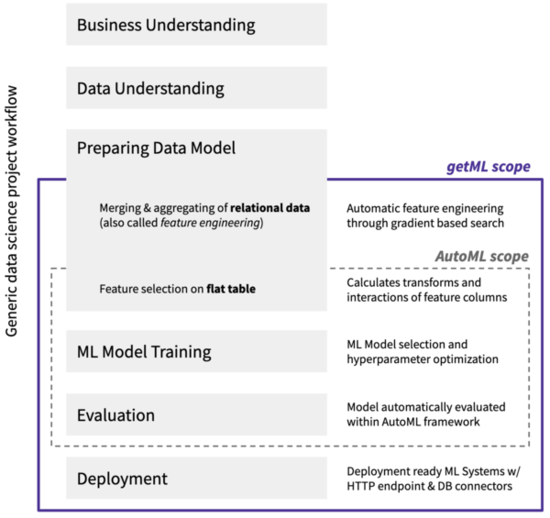

In [2]:
Image("img/getml_scheme.png")

getML adds automated feature engineering on relational data and time series to AutoML. The getML algorithms, Multirel and Relboost, find the right aggregations and subconditions needed to construct meaningful features from the raw relational data. This is done by performing a sophisticated, gradient-boosting-based heuristic. In doing so, getML brings the vision of end-to-end automation of machine learning within reach for the first time. Note that getML also includes automated model deployment via a HTTP endpoint or database connectors. This topic is covered in other material.

All functionality of getML is implemented in the so-called _getML engine_. It is written in C++ to achieve the highest performance and efficiency possible and is responsible for all the heavy lifting. The getML Python API acts as a bridge to communicate with engine. In addition, the _getML monitor_ provides a Go-based graphical user interface to ease working with getML and significantly accelerate your workflow.

In this article you will learn the basic steps and commands to tackle your data science projects using the Python API. For illustration purpose we will also touch how an example data set like the one used here would have been dealt with using classical data science tools. In contrast, we will show how the most tedious part of a data science project - merging and aggregating a relation data set - is automated using getML. At the end of this tutorial you are ready to tackle your own use cases with getML or dive deeper into our software using a variety of follow-up material.

## Starting a new project

After you've successfully [installed](https://docs.get.ml/latest/home/installation/installation.html) getML, you can launch it by executing the `getml-cli` command line interface or double-clicking the application icon. This launches both the getML engine and monitor.

Before diving into the actual project, you need to log into the getML suite. This happens in the getML Monitor, the frontend to the engine. If you open the browser of your choice and visit http://localhost:1709/, you'll see a login screen. Click 'create new account' and follow the indicated steps. After you've activated your account by clicking the link in the activation email you're ready to go. From now on, the entire analysis is run from Python. We will cover the getML monitor in a later tutorial but feel free to check what is going on while following this guide.

In [3]:
import getml
print("getML version: {}".format(getml.__version__))

getML version: 0.12.0-datasets.1


First, we create a new project. All data sets and pipelines belonging to a project will be stored in ``~/.getML/getml-VERSION/projects``.

In [4]:
getml.engine.set_project('getting_started')

Creating new project 'getting_started'


### Data set

The data set used in this tutorial consists of 2 tables. The so-called population table represents the entities we want to make a prediction about in the analysis. The peripheral table contains additional information and is related to the population table via a join key. Such a data set could appear for example in a customer churn analysis where each row in the population table represents a customer and each row in the peripheral table represents a transaction. It could also be part of a predictive maintenance campaign where each row in the population table corresponds to a particular machine in a production line and each row in the peripheral table to a measurement from a certain sensor.

In this guide, however, we do not assume any particular use case. After all, getML is applicable to a wide range of problems from different domains. Use cases from specific fields are covered in other articles.

In [5]:
population_table, peripheral_table = getml.datasets.make_numerical(
    n_rows_population=500,
    n_rows_peripheral=100000,
    random_state=1709
)

# Save data frames to disk in order to make them available after restarting the engine
population_table = population_table.save()
peripheral_table = peripheral_table.save()

This is the resulting population table

In [6]:
population_table

Name,time_stamp,join_key,targets,column_01
Role,time_stamp,join_key,target,numerical
Unit,"time stamp, comparison only",,,
0,1970-01-01T00:00:00.470834Z,0,101,-0.629518
1,1970-01-01T00:00:00.899782Z,1,88,-0.962169
2,1970-01-01T00:00:00.085734Z,2,17,0.732649
3,1970-01-01T00:00:00.365223Z,3,74,-0.462678
4,1970-01-01T00:00:00.442957Z,4,96,-0.837399
,...,...,...,...
495,1970-01-01T00:00:00.945288Z,495,93,0.499767
496,1970-01-01T00:00:00.518100Z,496,101,-0.465699


The population table contains 4 columns. The column called `column_01` contains a random numerical value. The next column, `targets`, is the one we want to predict in the analysis. To this end, we also need to use the information from the peripheral table. 

The relationship between the population and peripheral table is established using the `join_key` and `time_stamp` columns: Join keys are used to connect one or more rows from one table with one or more rows from the other table. Time stamps are used to limit these joins, thus ensuring that no data from the future is used during the training.

The peripheral table looks like this:

In [7]:
peripheral_table

Name,time_stamp,join_key,column_01
Role,time_stamp,join_key,numerical
Unit,"time stamp, comparison only",,
0,1970-01-01T00:00:00.325719Z,26,-0.296267
1,1970-01-01T00:00:00.759282Z,12,0.592168
2,1970-01-01T00:00:00.361653Z,42,-0.985272
3,1970-01-01T00:00:00.189929Z,295,0.226407
4,1970-01-01T00:00:00.545911Z,321,-0.443054
,...,...,...
99995,1970-01-01T00:00:00.475329Z,213,0.946612
99996,1970-01-01T00:00:00.554356Z,16,-0.809395


In the peripheral table, `columns_01` also contains a random numerical value. The population table and the peripheral table have a one-to-many relationship via `join_key`. This means that one row in the population table is associated to many rows in the peripheral table. In order to use the information from the peripheral table, we need to merge the many rows corresponding to one entry in the population table into so-called features. This done using certain aggregations.

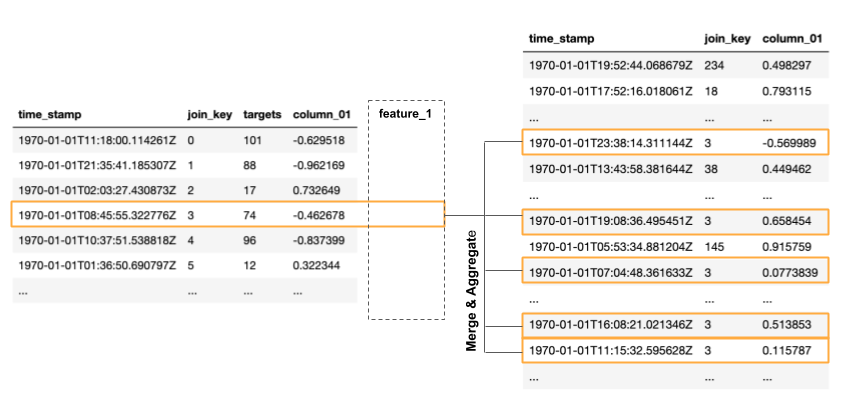

In [8]:
Image("img/getting_started_pic1.png")

For example, such an aggregation could be the sum of all values in `column_01`. We could also apply a subcondition, like taking only values into account that fall into a certain time range with respect to the entry in the population table. In SQL code such a feature would look like this:

```sql
SELECT COUNT( * )
FROM POPULATION t1
LEFT JOIN PERIPHERAL t2
ON t1.join_key = t2.join_key
WHERE (
   ( t1.time_stamp - t2.time_stamp <= TIME_WINDOW )
) AND t2.time_stamp <= t1.time_stamp
GROUP BY t1.join_key,
     t1.time_stamp;
```

Unfortunately, neither the right aggregation nor the right subconditions are clear a priori. The feature that allows us to predict the target best could very well be e.g. the average of all values in `column_01` that fall below a certain threshold, or something completely different. If you were to tackle this problem with classical machine learning tools, you would have to write many SQL features by hand and find the best ones in a trial-and-error-like fashion. At best, you could apply some domain knowledge that guides you towards the right direction. This approach, however, bears two major disadvantages that prevent you from finding the best-performing features.

1. You might not have sufficient domain knowledge.
2. You might not have sufficient resources for such a time-consuming, tedious, and error-prone process.

This is where getML comes in. It finds the correct features for you - automatically. You do not need to manually merge and aggregate tables in order to get started with a data science project. In addition, getML uses the derived features in a classical AutoML setting to easily make predictions with established and well-performing algorithms. This means getML provides an end-to-end solution starting from the relational data to a trained ML-model. How this is done via the getML Python API is demonstrated in the following.

## Defining the data model

The next step is finding features in the data that allow an accurate prediction of the target variable in the population table. This is achieved using a `MultirelModel`. This pipeline is responsible for the entire process from feature learning to predicting the target variable based on the generated features. The `MultirelModel` requires a predefined data model in order to efficiently represent the data in memory. This is achieved via `Placeholder`s. Placeholders are abstract representations of `DataFrame`s and their relations.

In [9]:
population_placeholder = getml.data.Placeholder("POPULATION")

peripheral_placeholder = getml.data.Placeholder("PERIPHERAL")

population_placeholder.join(peripheral_placeholder,
                            join_key="join_key",
                            time_stamp="time_stamp")


Now we can define the pipeline. In addition to the `Placeholder`s representing the `DataFrame`s you also have to provide a predictor. Additionally, you can alter some hyperparameters like the number of features you want to train or the list of aggregations to select from when building features.

In [10]:
feature_learner = getml.feature_learning.MultirelModel(
   aggregation=[
        getml.feature_learning.aggregations.Count,
        getml.feature_learning.aggregations.Sum
    ], 
    num_features=10,
    max_length=1,
    num_threads=1
)

predictor = getml.predictors.LinearRegression()

pipe = getml.pipeline.Pipeline(
    population=population_placeholder,
    peripheral=[peripheral_placeholder],
    feature_learners=feature_learner,
    predictors=predictor
)

We have chosen a narrow search field in aggregation space by only letting the algorithm use ``Count`` and ``Sum``. For the sake of demonstration, we use a simple `LinearRegression` and construct only 10 different features. In real world projects you would construct at least ten times this number and get results significantly better than what we will achieve here.

## Training a pipeline

When fitting the pipeline, we pass the handlers to the actual data residing in the getML engine - the `DataFrame`s.

In [11]:
pipe = pipe.fit(
    population_table=population_table,
    peripheral_tables={"PERIPHERAL": peripheral_table}
)

Checking data model...
OK.

MultirelModel: Training features...
[========================================] 100%

MultirelModel: Building features...
[========================================] 100%

LinearRegression: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:0.385257



That's it. The Multirel feature learning routines as well as the `LinearRegression` contained in the `MultirelModel` are now trained on our test data set. 

### Scoring the pipeline

Let's generate another population table as validation data set in order to see how well the trained model performs on new data. For numerical predictions this results in three different scores: mean absolute error (MAE), root mean squared error (RMSE), and the square correlation coefficient (rsquared).

In [12]:
population_table_score, peripheral_table_score = getml.datasets.make_numerical(
    n_rows_population=200,
    n_rows_peripheral=8000,
    random_state=1710
)

scores = pipe.score(
    population_table=population_table_score,
    peripheral_tables={"PERIPHERAL": peripheral_table_score}
)

print("Mean absolute error: {:.3f}".format(scores['mae'][0]))
print("R-squared: {:.3f}".format(scores['rsquared'][0]))


MultirelModel: Building features...
[========================================] 100%

Mean absolute error: 0.050
R-squared: 1.000


Our pipeline is able to predict the target variable in the newly generated data set very accurately.

### Making predictions

You can also make predictions using the pipeline you have just trained

In [13]:
population_table_predict, peripheral_table_predict = getml.datasets.make_numerical(
    n_rows_population=200,
    n_rows_peripheral=8000,
    random_state=1711
)


yhat = pipe.predict(
    population_table=population_table_predict,
    peripheral_tables={"PERIPHERAL": peripheral_table_predict}
)

print(yhat[:10])


MultirelModel: Building features...
[========================================] 100%

[[ 4.9591616 ]
 [13.977852  ]
 [23.95826771]
 [ 0.94152816]
 [26.92489167]
 [19.96818708]
 [15.97652356]
 [ 3.96327305]
 [18.95206619]
 [24.97750877]]


### Extracting features

Of course you can also transform a specific data set into the corresponding features in order to insert them into another machine learning algorithm.

In [14]:
features = pipe.transform(
    population_table=population_table_predict,
    peripheral_tables={"PERIPHERAL": peripheral_table_predict}
)

print(features)


MultirelModel: Building features...
[========================================] 100%

[[ 0.26285526 -1.70947651  5.         ...  5.          0.99524429
  -0.31856832]
 [ 3.61423201 -3.91860768 14.         ... 14.          3.80100605
   0.39465668]
 [ 5.92441112 -9.14946009 24.         ... 24.          6.66300574
   0.12470039]
 ...
 [ 0.94089783 -1.05020513  8.         ...  8.          2.00532951
  -0.74996369]
 [ 2.11562428 -5.46074531 15.         ... 15.          1.90051102
  -0.72788024]
 [ 0.05360352 -0.58945     2.         ...  2.          0.6167304
  -0.35370042]]


If you want to see the SQL code for each feature, you can do so by clicking on the feature in the monitor or calling the `to_sql` method on the `MultirelModel`. The definition of feature_2 is

```sql
CREATE TABLE "FEATURE_1_3" AS
SELECT COUNT( * ) AS "feature_1_3",
       t1.rowid AS "rownum"
FROM "POPULATION" t1
LEFT JOIN "PERIPHERAL" t2
ON t1."join_key" = t2."join_key"
WHERE (
   ( ( datetime( t1."time_stamp" ) <= datetime( t2."time_stamp", '+0.499075 seconds' ) ) )
) AND datetime( t2."time_stamp" ) <= datetime( t1."time_stamp" )
GROUP BY t1.rowid;
```


This very much resembles the ad hoc definition we tried in the beginning. The correct aggregation to use on this data set is `Count` with the subcondition that only entries within a time window of 0.5 are considered. getML extracted this definition completely autonomously.

## Next steps

This guide has shown you the very basics of getML. Starting with raw data you have completed a full project including feature learning and linear regression using an automated end-to-end pipeline. The most tedious part of this process - finding the right aggregations and subconditions to construct a feature table from the relational data model - was also included in this pipeline. 


But there's more! Check out the [documentation](https://docs.getml.com) for detailed information on how to work with getML. There are also related articles showing application of getML on real world data sets.

Also, don't hesitate to [contact us](https://get.ml/contact/lets-talk) with your feedback.